In [33]:
# LT: Exclude DepDelay
# ST: Include DepDelay
# Classification: Predict if arrdelay > 0

# Import Necessary Package here
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, f1_score
from sklearn import metrics
from sklearn import preprocessing
import gc

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier, plot_importance

import matplotlib.pyplot as plt

# Data Import

In [2]:
# Load CSV 
df = pd.read_csv(r"C:\Users\19665\Documents\ORIE-4741-Project\2016_to_2020_flight_feature_eng_w_Dest_10_10.csv")

In [3]:
df = df.drop('Unnamed: 0', axis = 1)
df.columns

Index(['Year', 'Month', 'DayofMonth', 'DepDelay', 'ArrDelay', 'CRSElapsedTime',
       'Distance', 'Severe-Cold_Severity', 'Fog_Severity', 'Hail_Severity',
       'Rain_Severity', 'Snow_Severity', 'Storm_Severity',
       'Other Precipitation_Severity', 'CRSDep_afternoon', 'CRSDep_midnight',
       'CRSDep_morning', 'CRSDep_night', 'CRSArr_afternoon', 'CRSArr_midnight',
       'CRSArr_morning', 'CRSArr_night', 'Q1', 'Q2', 'Q3', 'Q4', 'Mon', 'Tue',
       'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Airline_9E', 'Airline_AA',
       'Airline_AS', 'Airline_B6', 'Airline_DL', 'Airline_EV', 'Airline_F9',
       'Airline_G4', 'Airline_MQ', 'Airline_NK', 'Airline_OH', 'Airline_OO',
       'Airline_UA', 'Airline_VX', 'Airline_WN', 'Airline_YV', 'Airline_YX',
       'Origin_ATL', 'Origin_CLT', 'Origin_DEN', 'Origin_DFW', 'Origin_LAS',
       'Origin_LAX', 'Origin_MCO', 'Origin_ORD', 'Origin_PHX', 'Origin_SEA',
       'Dest_ATL', 'Dest_CLT', 'Dest_DEN', 'Dest_DFW', 'Dest_LAS', 'Dest_LAX',
       'Dest_M

In [4]:
# Check all columns are in numeric form
df.dtypes[df.dtypes != 'int64'][df.dtypes != 'float64']

Series([], dtype: object)

In [5]:
# Check NA value 
df.isnull().values.any()

False

In [6]:
# Turn Regression into classification problem
df['is_late'] = df['ArrDelay'] > 0
df = df.drop(columns = ['ArrDelay'])

In [7]:
# Inspect all columns
pd.set_option('display.max_columns', None)
df.head() 

,Year,Month,DayofMonth,DepDelay,CRSElapsedTime,Distance,Severe-Cold_Severity,Fog_Severity,Hail_Severity,Rain_Severity,Snow_Severity,Storm_Severity,Other Precipitation_Severity,CRSDep_afternoon,CRSDep_midnight,CRSDep_morning,CRSDep_night,CRSArr_afternoon,CRSArr_midnight,CRSArr_morning,CRSArr_night,Q1,Q2,Q3,Q4,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Airline_9E,Airline_AA,Airline_AS,Airline_B6,Airline_DL,Airline_EV,Airline_F9,Airline_G4,Airline_MQ,Airline_NK,Airline_OH,Airline_OO,Airline_UA,Airline_VX,Airline_WN,Airline_YV,Airline_YX,Origin_ATL,Origin_CLT,Origin_DEN,Origin_DFW,Origin_LAS,Origin_LAX,Origin_MCO,Origin_ORD,Origin_PHX,Origin_SEA,Dest_ATL,Dest_CLT,Dest_DEN,Dest_DFW,Dest_LAS,Dest_LAX,Dest_MCO,Dest_ORD,Dest_PHX,Dest_SEA,is_late
0,2016,1,1,0.0,148.0,868.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,False
1,2016,1,2,11.0,148.0,868.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,False
2,2016,1,3,11.0,148.0,868.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,False
3,2016,1,4,2.0,148.0,868.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,True
4,2016,1,5,558.0,149.0,868.0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,True


# Long vs Short Term Model
As discussed in porposal, we will have two models, one predicting delay before passengers arrive at the airport, and the other one predict delay using all data avaliable until the plane left the ground.

Here, some columns contain data that will only be avaliable when the passengers board the plane (like DepDelay and Weather). We cannot use them in our long-run forecase, but we can include them in our short-run forecast.

In [8]:
weather_columns = ['Severe-Cold', 'Fog', 'Hail', 'Rain', 'Snow', 'Storm', 'Other Precipitation']
ST_columns = ['DepDelay'] 
df_LT = df[df.columns.difference(ST_columns)]
# df_ST = df

In [9]:
del [[df]]
gc.collect()

0

In [10]:
# Specify X and y
X = df_LT.drop(columns = ['is_late'])
y = pd.DataFrame(df_LT['is_late'])

# X = df_ST.drop(columns = ['is_late'])
# y = pd.DataFrame(df_ST['is_late'])


# Perform train-test-validation split (Train: 0.6, test: 0.2, Val: 0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [11]:
X_val.shape

(393817, 68)

In [12]:
X_test.shape

(393817, 68)

In [13]:
X_train.shape

(1181450, 68)

In [26]:
X_train_10, _, y_train_10, _ = train_test_split(X_train, y_train, test_size=0.9)

In [27]:
X_train_10.shape

(118145, 68)

In [64]:
def plot_feature_importances(model, feature_names):
    n_features = len(feature_names)
    plt.figure(figsize=(10, 30))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel('Feature importance')
    plt.ylabel('Features')
    plt.grid(True)

# Gradient Boosting (LT)
As a start, we will fit a Gradient Boosting with y = is_late. As the dataset is inbalanced, we would use the weighted avg of F-1 score as our evaluation metrics
## Baseline Model

In [14]:
subsample_size =  0.01
max_depth = 5
learning_rate = 0.1
n_estimators = 100


grad_boosting = GradientBoostingClassifier(learning_rate = learning_rate, 
                                           subsample = subsample_size, 
                                           max_depth = max_depth, 
                                           n_estimators = n_estimators, 
                                           verbose = 1, )

In [15]:
grad_boosting.fit(X_train, y_train.values.ravel())

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3010           0.0047           21.29s
         2           1.2953           0.0046           21.07s
         3           1.3025           0.0039           21.64s
         4           1.2970           0.0034           21.12s
         5           1.2930           0.0029           20.68s
         6           1.2906           0.0026           20.42s
         7           1.2907           0.0021           20.27s
         8           1.2867           0.0020           20.00s
         9           1.2794           0.0019           19.89s
        10           1.2796           0.0014           19.66s
        20           1.2784           0.0007           17.61s
        30           1.2655           0.0006           15.46s
        40           1.2596           0.0002           13.25s
        50           1.2570           0.0002           11.05s
        60           1.2633           0.0001            8.85s
       

GradientBoostingClassifier(max_depth=5, subsample=0.01, verbose=1)

In [16]:
# See train  
pred = grad_boosting.predict(X_train)
print(classification_report(y_train.values.ravel(), pred))

              precision    recall  f1-score   support

       False       0.67      0.92      0.77    748155
        True       0.60      0.20      0.30    433295

    accuracy                           0.66   1181450
   macro avg       0.63      0.56      0.54   1181450
weighted avg       0.64      0.66      0.60   1181450



In [17]:
# See test  
pred = grad_boosting.predict(X_test)
print(classification_report(y_test.values.ravel(), pred))

              precision    recall  f1-score   support

       False       0.67      0.92      0.77    249419
        True       0.60      0.20      0.30    144398

    accuracy                           0.66    393817
   macro avg       0.63      0.56      0.54    393817
weighted avg       0.64      0.66      0.60    393817



### Dummy Majority Classifier Result

In [19]:
# See dummy majority classfier
pred = np.zeros(y_test.values.shape[0])
print(classification_report(y_test.values.ravel(), pred))

C:\Users\19665\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\19665\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       False       0.63      1.00      0.78    249222
        True       0.00      0.00      0.00    144595

    accuracy                           0.63    393817
   macro avg       0.32      0.50      0.39    393817
weighted avg       0.40      0.63      0.49    393817



C:\Users\19665\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The model underfits

## Feature Scaling and Normalization
Although most of our data features are one-hot generated, features like year and distance are order-of-magitude different from 1 and 0. We would like to see if normalizing all features to the same scale could help mitigate this disrepency. In theory the scale of the data should not affect how tree-based classification methods are trained

In [20]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
# Use same scaler obtained from training sample because test data are supposed to be completely unknown
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [21]:
grad_boosting.fit(X_train_scaled, y_train.values.ravel())

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.3089           0.0052            2.93m
         2           1.3042           0.0043            2.94m
         3           1.2995           0.0039            2.92m
         4           1.2977           0.0033            2.87m
         5           1.2946           0.0030            2.82m
         6           1.2912           0.0024            2.79m
         7           1.2893           0.0021            2.76m
         8           1.2876           0.0021            2.73m
         9           1.2864           0.0016            2.70m
        10           1.2834           0.0021            2.67m
        20           1.2722           0.0008            2.35m
        30           1.2630           0.0004            2.06m
        40           1.2587           0.0005            1.75m
        50           1.2548           0.0002            1.45m
        60           1.2508           0.0005            1.15m
       

GradientBoostingClassifier(max_depth=5, subsample=0.3, verbose=1)

In [22]:
# See Test 
pred = grad_boosting.predict(X_test_scaled)
print(classification_report(y_test.values.ravel(), pred))

              precision    recall  f1-score   support

       False       0.66      0.94      0.78    249222
        True       0.63      0.18      0.28    144595

    accuracy                           0.66    393817
   macro avg       0.65      0.56      0.53    393817
weighted avg       0.65      0.66      0.60    393817



### Conclusion
We are able to confirm that normalization is **not** helpful for Boosting Tree classifier

## Hyperparameter Tuning
Since more tree does not typicaly leads to overfit, we decided to tune the other parameters, and then use more trees in the final model. We decided to optimize the following hyperparameters:
1. Criterion
2. Max depth of each tree
3. Fraction of Samples used to generate each tree

There exits other hyperparameters that we are not optimizing, because we believe they do not carry a large impact on the performance of the model

In [18]:
parameters =  [{'max_depth': [5, 10, 50, 100], 'n_estimators' :[100]}]
clf = GridSearchCV(GradientBoostingClassifier(subsample=0.01,learning_rate=0.1), parameters, scoring='f1_weighted', n_jobs = 8, verbose = 3, cv = 2)
clf.fit(X_train, y_train.values.ravel())

Fitting 2 folds for each of 4 candidates, totalling 8 fits


GridSearchCV(cv=2, estimator=GradientBoostingClassifier(subsample=0.01),
             n_jobs=8,
             param_grid=[{'max_depth': [5, 10, 50, 100],
                          'n_estimators': [100]}],
             scoring='f1_weighted', verbose=3)

In [19]:
print(clf.best_params_)

{'max_depth': 10, 'n_estimators': 100}


## Final Model
Our final RandomForest model has the following parameters:
tree_size = 10
estimator = 100



In [20]:
subsample_size =  0.1
max_depth = 20
learning_rate = 0.1
n_estimators = 100


grad_boosting = GradientBoostingClassifier(learning_rate = learning_rate, 
                                           subsample = subsample_size, 
                                           max_depth = max_depth, 
                                           n_estimators = n_estimators, 
                                           verbose = 1, )


In [21]:
grad_boosting.fit(X_train, y_train.values.ravel())

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2975           0.0089            3.08m
         2           1.2923           0.0081            3.07m
         3           1.2862           0.0062            3.06m
         4           1.2809           0.0051            3.04m
         5           1.2769           0.0046            3.02m
         6           1.2714           0.0039            2.99m
         7           1.2677           0.0031            2.95m
         8           1.2663           0.0029            2.92m
         9           1.2578           0.0027            2.89m
        10           1.2571           0.0023            2.86m
        20           1.2435           0.0007            2.55m
        30           1.2260           0.0006            2.22m
        40           1.2141           0.0003            1.90m
        50           1.2059           0.0005            1.58m
        60           1.2027           0.0002            1.26m
       

GradientBoostingClassifier(max_depth=10, subsample=0.1, verbose=1)

In [22]:
# See Train 
pred = grad_boosting.predict(X_train)
print(classification_report(y_train.values.ravel(), pred))

              precision    recall  f1-score   support

       False       0.69      0.91      0.79    748155
        True       0.66      0.31      0.42    433295

    accuracy                           0.69   1181450
   macro avg       0.67      0.61      0.60   1181450
weighted avg       0.68      0.69      0.65   1181450



In [23]:
# See Test 
pred = grad_boosting.predict(X_test)
print(classification_report(y_test.values.ravel(), pred))

              precision    recall  f1-score   support

       False       0.69      0.90      0.78    249419
        True       0.62      0.29      0.39    144398

    accuracy                           0.67    393817
   macro avg       0.65      0.59      0.59    393817
weighted avg       0.66      0.67      0.64    393817



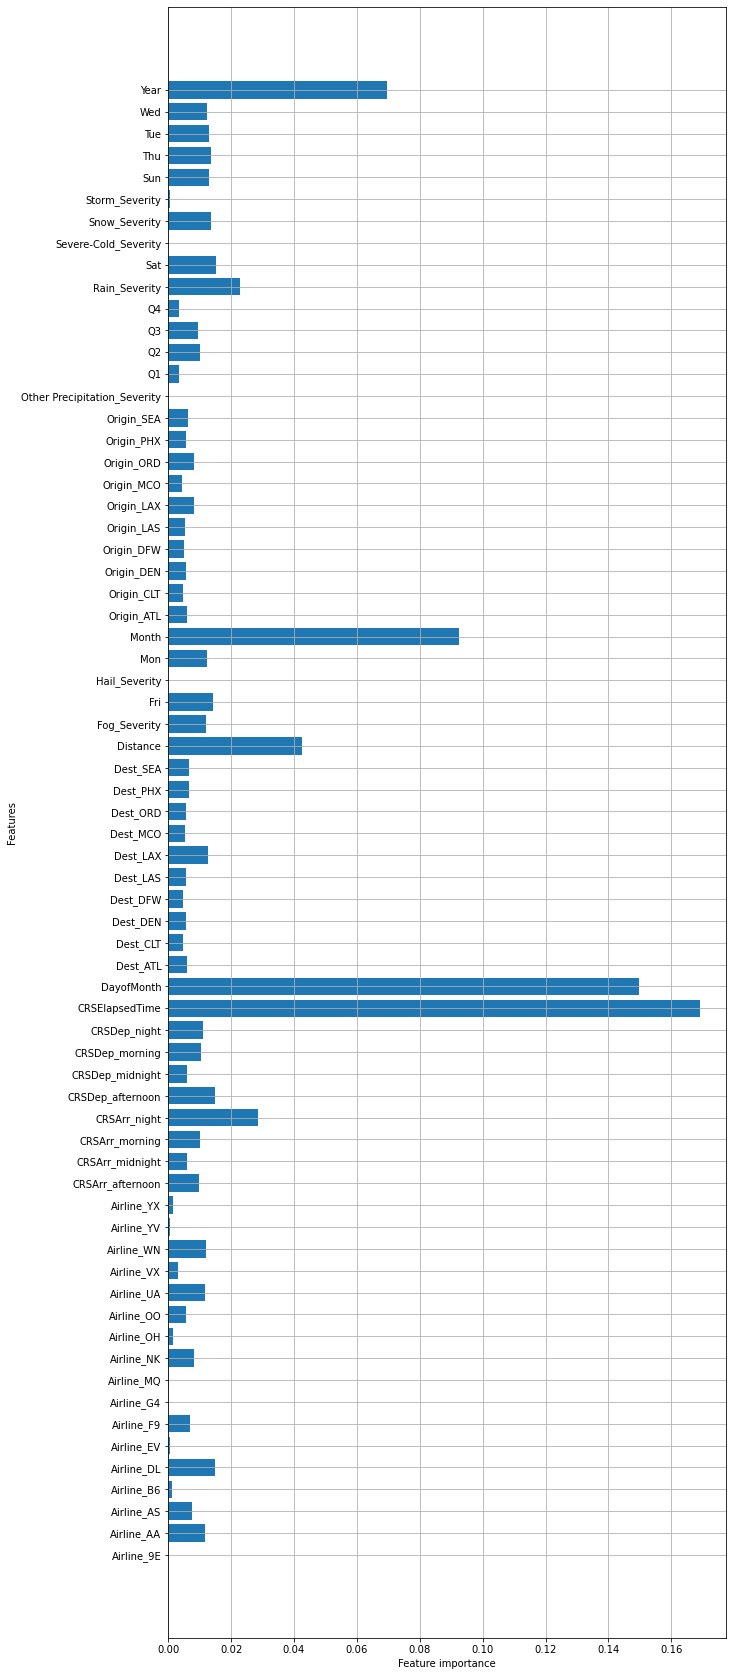

In [65]:
feature_names = X_train.columns.values
plot_feature_importances(grad_boosting, feature_names)

## AdaBoost

In [24]:
n_estimator = 100
ada_boosting = AdaBoostClassifier(n_estimators = n_estimator)

In [28]:
ada_boosting.fit(X_train_10, y_train_10.values.ravel())

AdaBoostClassifier(n_estimators=100)

In [29]:
# See Train 
pred = ada_boosting.predict(X_train)
print(classification_report(y_train.values.ravel(), pred))

              precision    recall  f1-score   support

       False       0.66      0.94      0.77    748155
        True       0.59      0.15      0.23    433295

    accuracy                           0.65   1181450
   macro avg       0.62      0.54      0.50   1181450
weighted avg       0.63      0.65      0.58   1181450



In [30]:
# See Test 
pred = ada_boosting.predict(X_test)
print(classification_report(y_test.values.ravel(), pred))

              precision    recall  f1-score   support

       False       0.66      0.94      0.77    249419
        True       0.59      0.15      0.24    144398

    accuracy                           0.65    393817
   macro avg       0.63      0.54      0.50    393817
weighted avg       0.63      0.65      0.58    393817



## Hyperparameter Tuning


In [31]:
for i in [1,5,10,20]:
    base_tree = DecisionTreeClassifier(max_depth = i)
    ada_boosting_alt = AdaBoostClassifier(base_estimator = base_tree, n_estimators = n_estimator)
    ada_boosting_alt.fit(X_train_10, y_train_10.values.ravel())
    # See Train 
    pred = ada_boosting_alt.predict(X_train)
    print(classification_report(y_train.values.ravel(), pred))
    # See Test 
    pred = ada_boosting_alt.predict(X_test)
    print(classification_report(y_test.values.ravel(), pred))
    print()

              precision    recall  f1-score   support

       False       0.66      0.94      0.77    748155
        True       0.59      0.15      0.23    433295

    accuracy                           0.65   1181450
   macro avg       0.62      0.54      0.50   1181450
weighted avg       0.63      0.65      0.58   1181450

              precision    recall  f1-score   support

       False       0.66      0.94      0.77    249419
        True       0.59      0.15      0.24    144398

    accuracy                           0.65    393817
   macro avg       0.63      0.54      0.50    393817
weighted avg       0.63      0.65      0.58    393817


              precision    recall  f1-score   support

       False       0.69      0.85      0.76    748155
        True       0.56      0.33      0.42    433295

    accuracy                           0.66   1181450
   macro avg       0.62      0.59      0.59   1181450
weighted avg       0.64      0.66      0.63   1181450

              prec

In [34]:
f1_score(y_test.values.ravel(), pred, average='weighted')

0.6110903277676034

In [66]:
base_tree = DecisionTreeClassifier(max_depth = 5)
ada_boosting_final = AdaBoostClassifier(base_estimator = base_tree, n_estimators = 100)
ada_boosting_final.fit(X_train, y_train.values.ravel())

# See Train 
pred = ada_boosting_final.predict(X_train)
print(classification_report(y_train.values.ravel(), pred))
# See val 
pred = ada_boosting_final.predict(X_val)
print(classification_report(y_val.values.ravel(), pred))

              precision    recall  f1-score   support

       False       0.70      0.88      0.78    748155
        True       0.62      0.33      0.43    433295

    accuracy                           0.68   1181450
   macro avg       0.66      0.61      0.61   1181450
weighted avg       0.67      0.68      0.65   1181450

              precision    recall  f1-score   support

       False       0.69      0.88      0.77    249454
        True       0.61      0.32      0.42    144363

    accuracy                           0.68    393817
   macro avg       0.65      0.60      0.60    393817
weighted avg       0.66      0.68      0.65    393817



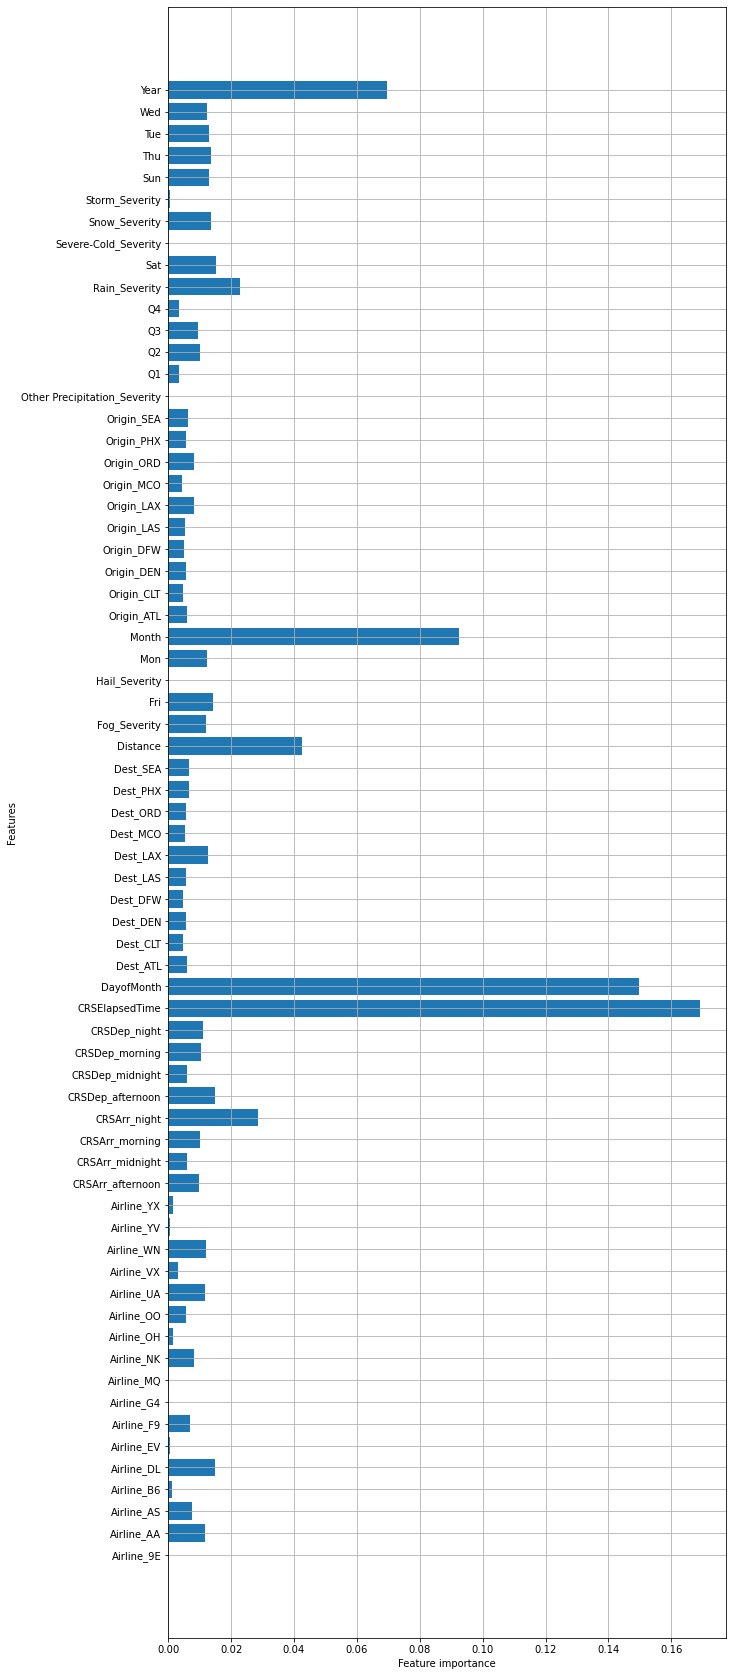

In [67]:
feature_names = X_train.columns.values
plot_feature_importances(grad_boosting, feature_names)

## XG Boost

In [43]:
# Base model

learning_rate = 0.1
max_depth = 6
subsample = 0.1

xg_boosting = XGBClassifier(
#     learning_rate = learning_rate,
#     max_depth = max_depth, 
#     min_child_weight=min_child_weight, 
    subsample= subsample, 
    verbosity = 1,
#     tree_method="gpu_hist",
)

In [45]:
xg_boosting.fit(X_train, y_train)

# See Train 
pred = xg_boosting.predict(X_train)
# print(f1_score(y_train.values.ravel(), pred, average='weighted'))
print(classification_report(y_train.values.ravel(), pred))

# See Val 
pred = xg_boosting.predict(X_val)
# print(f1_score(y_val.values.ravel(), pred, average='weighted'))
print(classification_report(y_val.values.ravel(), pred))

              precision    recall  f1-score   support

       False       0.68      0.90      0.78    748155
        True       0.62      0.28      0.39    433295

    accuracy                           0.67   1181450
   macro avg       0.65      0.59      0.58   1181450
weighted avg       0.66      0.67      0.63   1181450

              precision    recall  f1-score   support

       False       0.68      0.90      0.77    249454
        True       0.61      0.27      0.38    144363

    accuracy                           0.67    393817
   macro avg       0.64      0.59      0.58    393817
weighted avg       0.65      0.67      0.63    393817



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

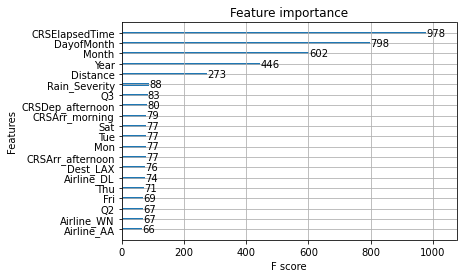

In [53]:
plot_importance(xg_boosting,max_num_features = 20)

In [50]:
# Model underfits, delayed flights had bad recall

In [48]:
# Test out model weight, as negative sample is ~ 1/2 of positive samples
xg_boosting_balanced = XGBClassifier(
#     learning_rate = learning_rate,
#     max_depth = max_depth, 
#     min_child_weight=min_child_weight, 
    scale_pos_weight = 1.72,
    subsample= subsample, 
    verbosity = 1,
#     tree_method="gpu_hist",
)

In [51]:
xg_boosting_balanced.fit(X_train, y_train)

# See Train 
pred = xg_boosting_balanced.predict(X_train)
# print(f1_score(y_train.values.ravel(), pred, average='weighted'))
print(classification_report(y_train.values.ravel(), pred))

# See Val 
pred = xg_boosting_balanced.predict(X_val)
# print(f1_score(y_val.values.ravel(), pred, average='weighted'))
print(classification_report(y_val.values.ravel(), pred))

C:\Users\19665\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[17:03:13] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

       False       0.74      0.65      0.69    748155
        True       0.50      0.60      0.55    433295

    accuracy                           0.63   1181450
   macro avg       0.62      0.63      0.62   1181450
weighted avg       0.65      0.63      0.64   1181450

              precision    recall  f1-score   support

       False       0.73      0.64      0.69    249454
        True       0.49      0.59      0.54    144363

    accuracy                           0.63    393817
   macro avg       0.61      0.62      0.61    393817
weighted avg       0.64      0.63      0.63    393817



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

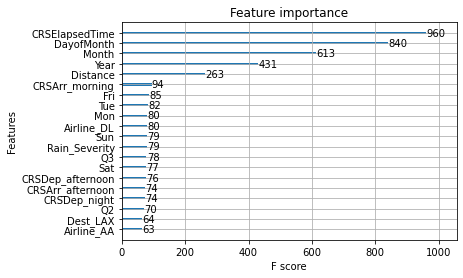

In [52]:
plot_importance(xg_boosting_balanced,max_num_features = 20)

Model underfits, increase complexity

In [54]:
# Tune tree depth
best_val_score = 0
best_mod = None
for i in [3,6,10,20,50]:
        xg_boosting = XGBClassifier(
                                learning_rate = learning_rate,
                                max_depth = i, 
                                subsample= subsample, 
                                scale_pos_weight = 1.72,
#                                 _estimators = n_estimators,
        )
        xg_boosting.fit(X_train, y_train)

        print(i)
        # See Train 
        pred = xg_boosting.predict(X_train)
        print(f1_score(y_train.values.ravel(), pred, average='weighted'))

        # See Val 
        pred = xg_boosting.predict(X_val)
        s = f1_score(y_val.values.ravel(), pred, average='weighted')
        print(s)
        if s > best_val_score:
            best_val_score = s
            best_mod = xg_boosting

        print('---')

C:\Users\19665\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[17:14:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
3
0.6081870913032774
0.6075346655744683
---


C:\Users\19665\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[17:14:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
6
0.6307241016396141
0.6281995614963751
---


C:\Users\19665\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[17:15:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
10
0.6605767391346827
0.6451804332447154
---


C:\Users\19665\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[17:16:13] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
20
0.7462385267966378
0.6537698601542772
---


C:\Users\19665\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[17:18:21] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
50
0.8006084890093912
0.6580180029898127
---


In [55]:
# best model is tree of depth 50, but due to the extended training time, we decided to use 20

In [58]:
# Check regularizations
best_val_score = 0
best_mod = None
for i in [0.75,1]:
    for j in [0.75,1]:
        xg_boosting = XGBClassifier(
            learning_rate = learning_rate,
            max_depth = 20, 
            subsample= subsample, 
            scale_pos_weight = 1.72,
            reg_lambda = i,
            reg_alpha = j   
        )
        xg_boosting.fit(X_train, y_train)

        print((i,j))
        # See Train 
        pred = xg_boosting.predict(X_train)
        print(f1_score(y_train.values.ravel(), pred, average='weighted'))

        # See Val 
        pred = xg_boosting.predict(X_val)
        s = f1_score(y_val.values.ravel(), pred, average='weighted')
        print(s)
        if s > best_val_score:
            best_val_score = s
            best_mod = xg_boosting

        print('---')

C:\Users\19665\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[17:36:46] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(0.75, 0.75)
0.7444168569036046
0.6561587729953882
---


C:\Users\19665\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[17:38:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(0.75, 1)
0.7425547031266185
0.6574707993815234
---


C:\Users\19665\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[17:40:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(1, 0.75)
0.74198254576619
0.6565911956189414
---


C:\Users\19665\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[17:42:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(1, 1)
0.7405897274835541
0.657421533768584
---


In [60]:
# Has little impact, find the best performing one

xg_boosting_final = XGBClassifier(
    learning_rate = learning_rate,
    max_depth = 20, 
    scale_pos_weight = 1.72,
    subsample= subsample, 
    verbosity = 1,
    reg_lambda = 0.75,
    reg_alpha = 1  
)

xg_boosting_final.fit(X_train, y_train)


# See Train 
pred = xg_boosting_final.predict(X_train)
# print(f1_score(y_train.values.ravel(), pred, average='weighted'))
print(classification_report(y_train.values.ravel(), pred))

# See Val 
pred = xg_boosting_final.predict(X_val)
# print(f1_score(y_val.values.ravel(), pred, average='weighted'))
print(classification_report(y_val.values.ravel(), pred))

C:\Users\19665\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\19665\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[17:47:23] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

       False       0.82      0.76      0.79    748155
        True       0.63      0.70      0.66    433295

    accuracy                           0.74   1181450
   macro avg       0.72      0.73      0.73   1181450
weighted avg       0.75      0.74      0.74   1181450

              precision    recall  f1-score   support

       False       0.74      0.70      0.72    249454
        True       0.53      0.58      0.55    144363

    accuracy                           0.65    393817
   macro avg       0.63      0.64      0.64    393817
weighted avg       0.66      0.65      0.66    393817



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

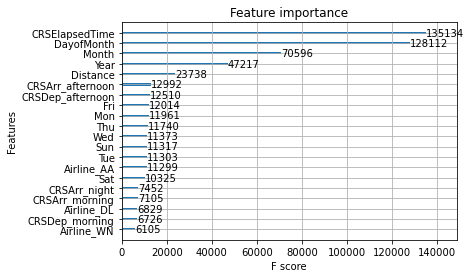

In [63]:
plot_importance(xg_boosting_final,max_num_features = 20)